In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
b_d = os.path.join("..","base_model_files")
nam_file = "freyberg.nam"

In [3]:
m = flopy.modflow.Modflow.load(nam_file,model_ws=b_d,check=False,forgive=False)
m.dis.nper = 2

In [4]:
m.exe_name = "mfnwt"
m.change_model_ws("temp",reset_external=True)
m.write_input()


changing model workspace...
   temp


In [5]:
m.run_model()

FloPy is using the following  executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 17:05:56

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 17:05:57
 Elapsed run time:  0.082 Seconds

  Normal termination of simulation


(True, [])

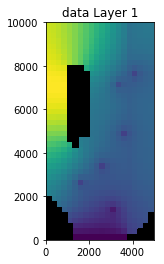

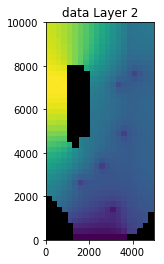

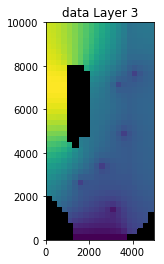

In [6]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
axes = hds.plot()

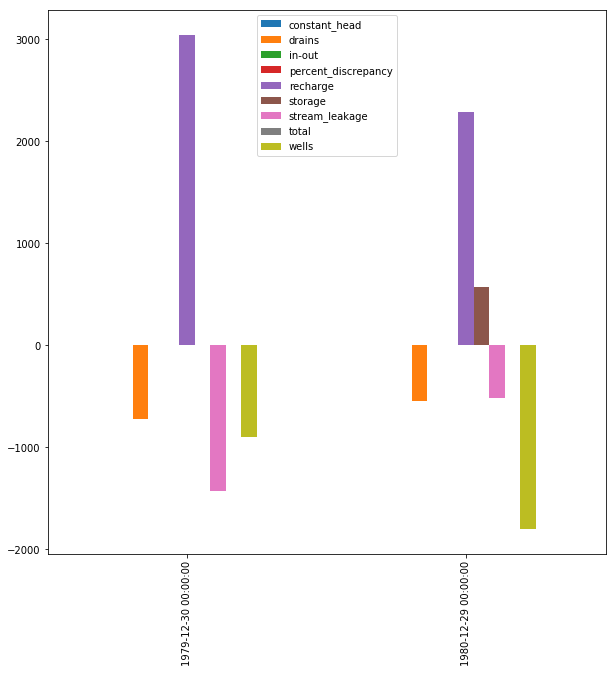

In [7]:
lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))

In [8]:
props = []
paks = ["upw.hk","upw.vka","upw.ss","upw.sy"]
for k in range(m.nlay):
    props.extend([[p,k] for p in paks])
props.append(["rch.rech",0])
props.append(["rch.rech",1])


In [14]:
spatial_list_props = [["wel.flux",2],["drn.cond",0]]
temporal_list_props = [["wel.flux",0],["wel.flux",1],["drn.elev",0],["drn.elev",1]]

In [15]:
hds_kperk = [[0,k] for k in range(m.nlay)]
hds_kperk = [[1,k] for k in range(m.nlay)]

In [16]:
sfr_obs_dict = {"hw":np.arange(1,21)}
sfr_obs_dict["tw"] = np.arange(20,40)
for i in range(m.nrow):
    sfr_obs_dict[i] = i+1

In [18]:
pst_helper = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws="template",org_model_ws="temp",
                                            const_props=props,spatial_list_props=spatial_list_props,
                                             temporal_list_props=temporal_list_props,remove_existing=True,
                                            grid_props=props,sfr_pars=True,hds_kperk=hds_kperk,
                                             sfr_obs=sfr_obs_dict,build_prior=False,model_exe_name="mfnwt")

2019-04-23 17:08:18.659666 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam

--------------------------------------------------
External unit dictionary:
OrderedDict([(2, filename:temp/freyberg.list, filetype:LIST), (11, filename:temp/freyberg.dis, filetype:DIS), (13, filename:temp/freyberg.bas, filetype:BAS6), (31, filename:temp/freyberg.upw, filetype:UPW), (19, filename:temp/freyberg.rch, filetype:RCH), (32, filename:temp/freyberg.nwt, filetype:NWT), (14, filename:temp/freyberg.oc, filetype:OC), (30, filename:temp/freyberg.lmt6, filetype:LMT6), (20, filename:temp/freyberg.wel, filetype:WEL), (17, filename:temp/freyberg.sfr, filetype:SFR), (21, filename:temp/freyberg.drn, filetype:DRN), (50, filename:temp/freyberg.cbc, filetype:DATA(BINARY)), (51, filename:temp/freyberg.hds, filetype:DATA(BINARY)), (60, filename:temp/freyberg.sfr.out, filetype:DATA)])
-------------------

2019-04-23 17:08:20.866270 finished: writing const tpl:ss3.dat_cn.tpl took: 0:00:00.006154
2019-04-23 17:08:20.868888 starting: writing const tpl:sy3.dat_cn.tpl
2019-04-23 17:08:20.875648 finished: writing const tpl:sy3.dat_cn.tpl took: 0:00:00.006760
2019-04-23 17:08:20.878888 starting: writing const tpl:hk4.dat_cn.tpl
2019-04-23 17:08:20.888510 finished: writing const tpl:hk4.dat_cn.tpl took: 0:00:00.009622
2019-04-23 17:08:20.896850 starting: writing const tpl:vka4.dat_cn.tpl
2019-04-23 17:08:20.911230 finished: writing const tpl:vka4.dat_cn.tpl took: 0:00:00.014380
2019-04-23 17:08:20.915011 starting: writing const tpl:ss4.dat_cn.tpl
2019-04-23 17:08:20.922590 finished: writing const tpl:ss4.dat_cn.tpl took: 0:00:00.007579
2019-04-23 17:08:20.925953 starting: writing const tpl:sy4.dat_cn.tpl
2019-04-23 17:08:20.933194 finished: writing const tpl:sy4.dat_cn.tpl took: 0:00:00.007241
2019-04-23 17:08:20.936764 starting: writing const tpl:hk5.dat_cn.tpl
2019-04-23 17:08:20.943751 finis

2019-04-23 17:08:22.313473 finished: processing obs type sfr took: 0:00:00.530452
2019-04-23 17:08:22.313942 changing dir in to template
2019-04-23 17:08:22.314777 starting: instantiating control file from i/o files
2019-04-23 17:08:22.887337 finished: instantiating control file from i/o files took: 0:00:00.572560
2019-04-23 17:08:23.085444 starting: writing forward_run.py
2019-04-23 17:08:23.086378 finished: writing forward_run.py took: 0:00:00.000934
2019-04-23 17:08:23.086477 writing pst template/freyberg.pst
noptmax: 0
2019-04-23 17:08:24.934911 starting: running pestchek on freyberg.pst
2019-04-23 17:08:25.404131 pestcheck:PESTCHEK Version 13.0. Watermark Numerical Computing.
2019-04-23 17:08:25.404600 pestcheck:
2019-04-23 17:08:25.404660 pestcheck:Errors ----->
2019-04-23 17:08:25.405043 pestcheck:No errors encountered.
2019-04-23 17:08:25.405119 pestcheck:
2019-04-23 17:08:25.405159 pestcheck:Warnings ----->
2019-04-23 17:08:25.405684 pestcheck:NUMLAM is supplied as negative. T

In [19]:
pst = pst_helper.pst
pst.npar,pst.nobs

(9945, 2319)

In [20]:
pst.parameter_data.pargp.value_counts()

grrech1        705
grsy2          705
grss1          705
grsy1          705
grvka0         705
grrech0        705
grhk1          705
grhk2          705
grsy0          705
grss2          705
grhk0          705
grss0          705
grvka2         705
grvka1         705
strk            40
drncond_k00     10
welflux_k02      6
drnelev          2
welflux          2
sy4_cn           1
sy5_cn           1
ss4_cn           1
hk5_cn           1
rech3_cn         1
ss3_cn           1
vka4_cn          1
sy3_cn           1
ss5_cn           1
vka5_cn          1
hk3_cn           1
flow             1
vka3_cn          1
hk4_cn           1
rech2_cn         1
Name: pargp, dtype: int64

In [21]:
pst.observation_data.obgnme.value_counts()

hds            2115
flout            84
flaqx            84
flx_storage       2
flx_stream_       2
vol_stream_       2
vol_storage       2
flx_recharg       2
vol_constan       2
flx_percent       2
vol_recharg       2
flx_wells         2
flx_constan       2
vol_drains        2
flx_in-out        2
flx_total         2
vol_percent       2
flx_drains        2
vol_total         2
vol_in-out        2
vol_wells         2
Name: obgnme, dtype: int64

In [23]:
pst.control_data.noptmax = 0
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=pst_helper.new_model_ws)

noptmax: 0


In [ ]:
pst.plot(kind="prior")

In [ ]:
pst_helper.build_prior()

In [ ]:
pe = pst_helper.draw(200)

In [ ]:
pe.iloc[0,:].plot(kind="hist")

In [ ]:
pe.to_csv(os.path.join(pst_helper.new_model_ws,"sweep_in.csv"))